# Análise explorátoria dos dados de treino/teste

##  Importação de bibliotecas e dados

In [111]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [112]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
df = pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow')
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,Debit (Prepaid),5497590243197280,07/2022,306,YES,2,55.0,05/2008,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Credit,5175842699412235,12/2024,438,YES,1,9100.0,09/2005,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Debit,5874992802287595,05/2020,256,YES,1,14802.0,01/2006,2008,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Debit,4354185735186651,01/2020,120,YES,1,19113.0,07/2009,2014,No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,89.0,01/2008,2015,No


## Ajuste no tipo de dado

In [114]:
df['target'].value_counts()

,count
target,
No,7394705
Yes,10665


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405370 entries, 0 to 7405369
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   client_id              int64         
 3   card_id                int64         
 4   amount                 float64       
 5   use_chip               object        
 6   merchant_id            int64         
 7   merchant_city          object        
 8   merchant_state         object        
 9   zip                    float64       
 10  mcc                    object        
 11  errors                 object        
 12  description            object        
 13  target                 object        
 14  current_age            int64         
 15  retirement_age         int64         
 16  birth_year             int64         
 17  birth_month            int64         
 18  gender                

In [178]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)
df['birth_year'] = df['birth_year'].astype(str)
df['birth_month'] = df['birth_month'].astype(str)


## Análise dos dados

In [117]:
def descritiva(df_, var, vresp: str, max_classes=5):
    """
    Gera um gráfico descritivo da taxa de sobreviventes por categoria da variável especificada.

    Parâmetros:
    df : DataFrame - Base de dados a ser analisada.
    var : str - Nome da variável categórica a ser analisada.
    """

    df = df_.copy()

    if df[var].nunique()>max_classes:
        df[var] = pd.qcut(df[var], max_classes, duplicates='drop')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    sns.pointplot(data=df, y=vresp, x=var, ax=ax1)

    # Criar o segundo eixo y para a taxa de sobreviventes
    ax2 = ax1.twinx()
    sns.countplot(data=df, x=var, palette='viridis', alpha=0.5, ax=ax2)
    ax2.set_ylabel('Frequência', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax1.set_zorder(2)
    ax1.patch.set_visible(False)  # Tornar o fundo do eixo 1 transparente

    # Exibir o gráfico
    plt.show()

### Análise temporal

In [146]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M').dt.to_timestamp(how='start')
df_time['target'] = df['target']
df_time.head()

,year,year_month,target
0,2010,2010-01-01,No
1,2010,2010-01-01,No
2,2010,2010-01-01,No
3,2010,2010-01-01,No
4,2010,2010-01-01,No


In [136]:
df_time_year = pd.pivot_table(df_time, index='year', columns='target', aggfunc='count').reset_index()
df_time_year.columns = ['year', 'target_no', 'target_yes']
df_time_year['total'] = df_time_year['target_no'] + df_time_year['target_yes']
df_time_year['percent_no'] = df_time_year['target_no'] / df_time_year['total']
df_time_year['percent_yes'] = df_time_year['target_yes'] / df_time_year['total']
df_time_year

,year,target_no,target_yes,total,percent_no,percent_yes
0,2010,828956,2573,831529,0.996906,0.003094
1,2011,863391,37,863428,0.999957,0.000043
2,2012,884498,923,885421,0.998958,0.001042
3,2013,905967,1337,907304,0.998526,0.001474
4,2014,914409,664,915073,0.999274,0.000726
5,2015,928035,2189,930224,0.997647,0.002353
6,2016,930314,2448,932762,0.997376,0.002624
7,2017,937112,172,937284,0.999816,0.000184
8,2018,202023,322,202345,0.998409,0.001591


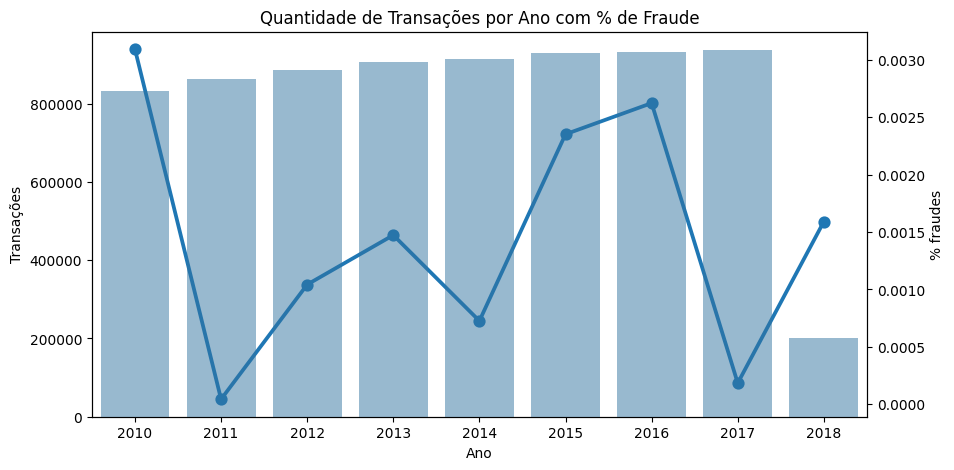

In [138]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Quantidade de Transações por Ano com % de Fraude')
sns.barplot(data=df_time_year, x='year', y='total', alpha=0.5, ax=ax1)
ax1.set_ylabel('Transações')
ax1.set_xlabel('Ano')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.pointplot(data=df_time_year, y='percent_yes', x='year', ax=ax2)

ax2.set_ylabel('% fraudes')

ax1.set_zorder(2)
ax1.patch.set_visible(False)

plt.show()

del df_time_year

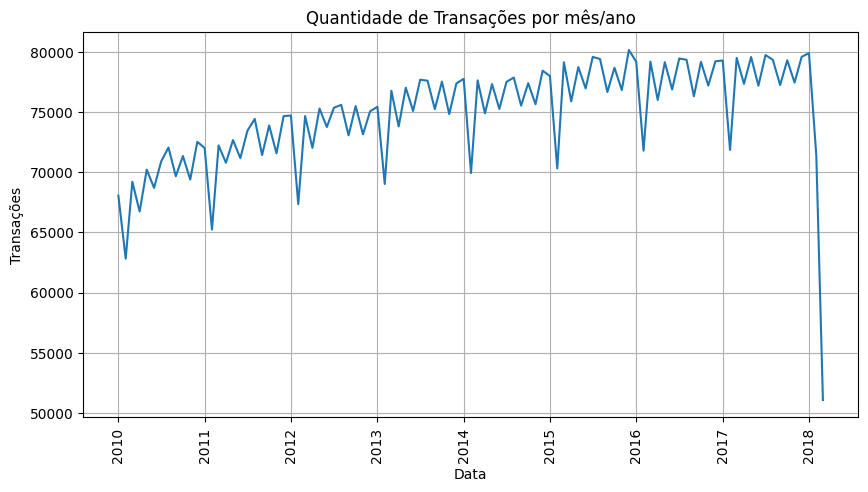

In [149]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Quantidade de Transações por mês/ano')
sns.lineplot(df_time['year_month'].value_counts().reset_index().sort_values('year_month', ascending=False).reset_index(drop=True), x='year_month', y='count', ax=ax1)
plt.xlabel('Data')
plt.ylabel('Transações')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Análise quantitativa

In [179]:
df.select_dtypes(include=['float64', 'int64']).columns

Index(['amount', 'current_age', 'retirement_age', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'num_cards_issued', 'credit_limit',
       'year_pin_last_changed'],
      dtype='object')

In [174]:
df_plot = pd.DataFrame()
df_plot['amount'] = pd.qcut(df['amount'], 20, duplicates='drop')
df_plot = pd.concat([df_plot, pd.get_dummies(df['target'], prefix='target', dtype=int)], axis=1)
df_plot.head()

,amount,target_No,target_Yes
0,"(-500.001, 0.0]",1,0
1,"(11.78, 14.98]",1,0
2,"(75.71, 87.94]",1,0
3,"(40.63, 47.69]",1,0
4,"(3.26, 5.83]",1,0


In [175]:
df_plot.groupby('amount').sum().reset_index()

<ipython-input-175-a77980a35cd2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('amount').sum().reset_index()


,amount,target_No,target_Yes
0,"(-500.001, 0.0]",374694,423
1,"(0.0, 1.72]",366971,494
2,"(1.72, 3.26]",368779,267
3,"(3.26, 5.83]",370006,319
4,"(5.83, 8.94]",370218,298
5,"(8.94, 11.78]",370090,203
6,"(11.78, 14.98]",369543,188
7,"(14.98, 18.92]",369669,216
8,"(18.92, 23.6]",370316,198
9,"(23.6, 29.03]",369643,242
